# **Análisis Exploratorio de Datos**

Las imágenes utilizadas en este estudio provienen de la iniciativa **Alzheimer’s Disease Neuroimaging Initiative (ADNI)**, un repositorio internacional de neuroimágenes longitudinales. Se seleccionaron exclusivamente imágenes estructurales T1‐ponderadas (MRI) correspondientes a sujetos con diagnóstico deterioro cognitivo leve (MCI) y demencia tipo Alzheimer (AD).

El dataset tabular proviene de los datos clínicos y neuropsicológicos asociados a las mismas visitas de imagen, conteniendo información sociodemográfica, genética, diagnóstica y volumétrica (FreeSurfer).

In [1]:
# [Config] Librerías
import pandas as pd
import os
import nibabel as nib
import re
import numpy as np
import pandas as pd
from datetime import datetime
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## DATOS TABULARES

In [2]:
# [Config] Rutas
df_tab = pd.read_csv("../Data/TABULAR.csv")
df_dx = pd.read_csv('../Data/ANDI_out.csv')

In [3]:
# Caracteristicas
print("CARACTERÍSTICAS\n")
print("======================"
      f"\n💿 Imágenes: {len(df_tab)}"
      f"\n👨‍🦳 Cantidad de pacientes: {df_dx['sujeto_id'].nunique()}"
      f"\n⏺️ Vistas dispobibles: {df_dx['Visit'].nunique()}, en los meses {df_tab['Visita'].unique()}"
      "\n======================"
)

# Progeso de la enfermedad
labels_por_sujeto = df_tab.groupby("sujeto_id")["label"].first()
tabla_1 = pd.DataFrame({
    "conteo": labels_por_sujeto.value_counts(),
    "porcentaje": labels_por_sujeto.value_counts(normalize=True).mul(100).round(2)
})
tabla_1.index = tabla_1.index.map({0: "No progreso", 1: "Progreso"})
display(tabla_1.style.set_caption("Distribución del progreso de la enfermedad"))

# Imágnes
tabla_2 = pd.DataFrame({
    "conteo": df_tab["is_dementia"].value_counts(),
    "porcentaje": df_tab["is_dementia"].value_counts(normalize=True).mul(100).round(2)
})
tabla_2.index = tabla_2.index.map({0: "MCI", 1: "Dementia"})
display(tabla_2.style.set_caption("Distribución de imágenes con Dementia"))

# Edad
print("======================"
      f"\n#️⃣ Edad de los pacientes:"
      f"\nMín: {df_tab['Age'].min()} | Máx: {df_tab['Age'].max()} | Mean: {df_tab['Age'].mean().round(2)}"
      "\n======================"
)

# Sexo
sex = df_tab.groupby("sujeto_id")["Sexo"].first()
tabla_3 = pd.DataFrame({
    "conteo": sex.value_counts(),
    "porcentaje": sex.value_counts(normalize=True).mul(100).round(2)
})
tabla_3.index = tabla_3.index.map({0: "Masculino", 1: "Femenino"})
display(tabla_3.style.set_caption("Distribución del sexo"))

# Nivel educativo
educat = {
    10: "10 años (básica incompleta)",
    12: "12 años (secundaria completa)",
    13: "13 años (secundaria + 1 año)",
    14: "14 años (preuniversitario)",
    16: "16 años (licenciatura)",
    17: "17 años (posgrado parcial)",
    18: "18 años (maestría)",
    19: "19 años (posgrado incompleto)",
    20: "20 años (doctorado/profesional)"
}
tabla_4 = pd.DataFrame({
    "conteo": df_tab["Educat"].value_counts(),
    "porcentaje": df_tab["Educat"].value_counts(normalize=True).mul(100).round(2)
})
tabla_4.index = tabla_4.index.map(educat)
display(tabla_4.style.set_caption("Distribución de nivel educativo"))

CARACTERÍSTICAS

💿 Imágenes: 220
👨‍🦳 Cantidad de pacientes: 51
⏺️ Vistas dispobibles: 7, en los meses [ 6 12 18 24 36 48 60]


,conteo,porcentaje
label,,
No progreso,31,60.780000
Progreso,20,39.220000


,conteo,porcentaje
is_dementia,,
MCI,158,71.820000
Dementia,62,28.180000


#️⃣ Edad de los pacientes:
Mín: 61 | Máx: 91 | Mean: 75.79


,conteo,porcentaje
Sexo,,
Masculino,38,74.510000
Femenino,13,25.490000


,conteo,porcentaje
Educat,,
16 años (licenciatura),62,28.180000
18 años (maestría),53,24.090000
20 años (doctorado/profesional),31,14.090000
19 años (posgrado incompleto),19,8.640000
12 años (secundaria completa),17,7.730000
14 años (preuniversitario),14,6.360000
10 años (básica incompleta),13,5.910000
17 años (posgrado parcial),6,2.730000
13 años (secundaria + 1 año),5,2.270000


Variables Volumétricas

* APOE4 es una variante genética de la apolipoproteína E 
    "CDRSB", #"Suma de cajas del Clinical Dementia Rating (CDR); mide la severidad de la demencia.",/
    "MMSE", #"Mini-Mental State Examination; evaluación global del estado cognitivo (máx. 30 puntos).",/
    "ADAS13", #"Alzheimer’s Disease Assessment Scale – 13 ítems; mide deterioro cognitivo en Alzheimer.",
    "FAQ", #"Functional Activities Questionnaire; evalúa la capacidad funcional en actividades diarias.",
    "RAVLT_immediate", # "Puntuación inmediata en la prueba verbal de aprendizaje (Rey Auditory Verbal Learning Test).",
    "RAVLT_learning", # "Puntuación de aprendizaje acumulado en RAVLT; mide retención verbal.",
    "RAVLT_forgetting", # "Índice de olvido en RAVLT; diferencia entre aprendizaje y recuerdo tardío.",
    "DIGITSCOR", #"Digit Span Score; mide memoria de trabajo y atención mediante secuencias numéricas.",
    "TRABSCOR", # "Trail Making Test B Score; evalúa función ejecutiva y flexibilidad cognitiva.",
]
volumen = [
    "Ventricles", # "Volumen de los ventrículos cerebrales; puede indicar atrofia cerebral.",
    "Hippocampus", # "Volumen del hipocampo; clave en memoria y afectado en Alzheimer.",
    "WholeBrain", # "Volumen total del cerebro; útil para evaluar atrofia global.",
    "Entorhinal", # "Volumen de la corteza entorrinal; región afectada tempranamente en Alzheimer.",
    "Fusiform", #"Volumen del giro fusiforme; relacionado con reconocimiento visual.",
    "MidTemp", # "Volumen del lóbulo temporal medio; implicado en memoria y procesamiento auditivo.",
    "ICV", #"Volumen intracraneal total; usado para normalizar medidas volumétricas."
]

In [4]:
df_tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sujeto_id             220 non-null    object 
 1   label                 220 non-null    int64  
 2   is_dementia           220 non-null    int64  
 3   Visita                220 non-null    int64  
 4   Age                   220 non-null    int64  
 5   Sexo                  220 non-null    int64  
 6   Educat                220 non-null    float64
 7   APOE4_std             220 non-null    float64
 8   CDRSB_std             220 non-null    float64
 9   MMSE_std              220 non-null    float64
 10  ADAS13_std            220 non-null    float64
 11  FAQ_std               220 non-null    float64
 12  RAVLT_immediate_std   220 non-null    float64
 13  RAVLT_learning_std    220 non-null    float64
 14  RAVLT_forgetting_std  220 non-null    float64
 15  DIGITSCOR_std         2

In [44]:
df_tab.columns

Index(['sujeto_id', 'label', 'is_dementia', 'Visita', 'Age', 'Sexo', 'Educat',
       'APOE4_std', 'CDRSB_std', 'MMSE_std', 'ADAS13_std', 'FAQ_std',
       'RAVLT_immediate_std', 'RAVLT_learning_std', 'RAVLT_forgetting_std',
       'DIGITSCOR_std', 'TRABSCOR_std', 'Ventricles_std', 'Hippocampus_std',
       'WholeBrain_std', 'Entorhinal_std', 'Fusiform_std', 'MidTemp_std',
       'ICV_std'],
      dtype='object')

### Diagnóstico

* Disponibilidad de visitas por sujeto

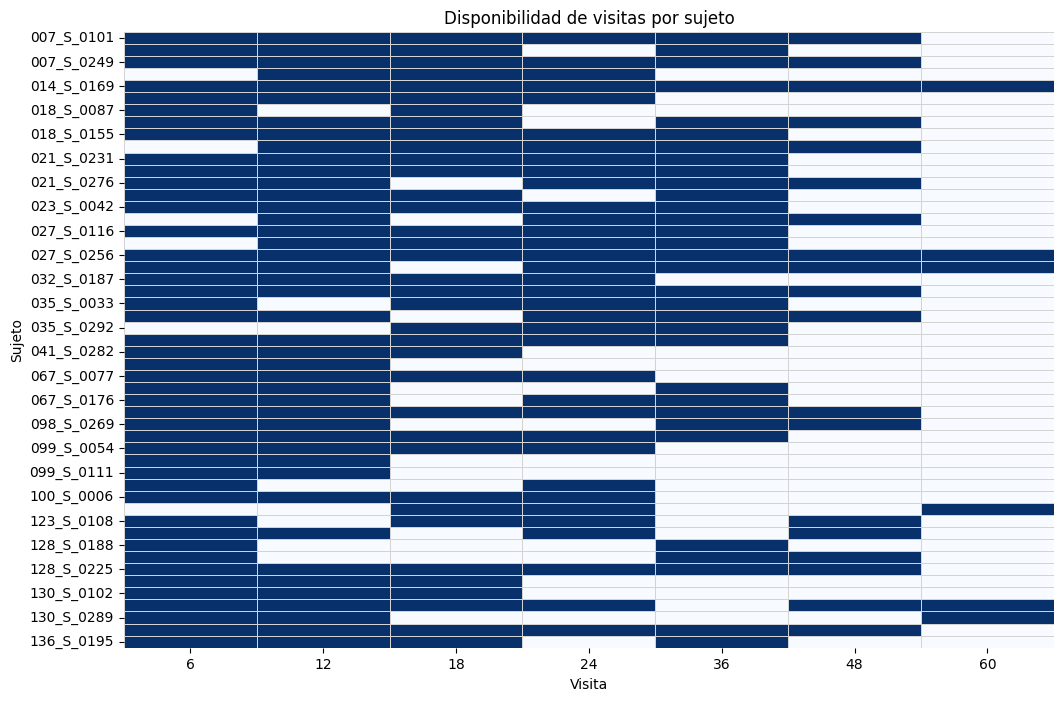

In [35]:
# Crear tabla de presencia de visitas por sujeto
# Asumiendo df tiene columnas: subject_id, Visita
df_visitas = df_tab.copy()
df_visitas['Presente'] = 1  # Marca cada fila como "visita existente"

tabla_visitas = df_visitas.pivot_table(
    index='sujeto_id',
    columns='Visita',
    values='Presente',
    aggfunc='last',
    fill_value=0
)
# Graficar heatmap
plt.figure(figsize=(12,8))
sns.heatmap(tabla_visitas, cmap="Blues", cbar=False, linewidths=0.5, linecolor='lightgray')
plt.title("Disponibilidad de visitas por sujeto")
plt.xlabel("Visita")
plt.ylabel("Sujeto")
plt.show()


* Años en estudio

,count
duracion_anios,
0,2
1,8
2,11
3,11
4,14
5,5


Text(0.5, 1.0, 'Años en estudio')

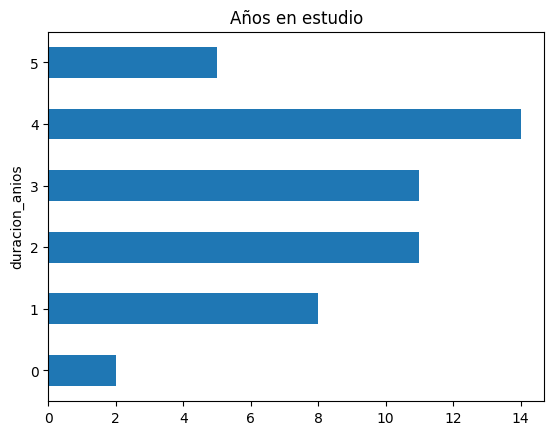

In [86]:
df_dx["fecha_imagen"] = pd.to_datetime(df_dx["fecha_imagen"])
df_dx["año"] = df_dx["fecha_imagen"].dt.year
df_duracion = df_dx.sort_values(["sujeto_id", "fecha_imagen"]).groupby("sujeto_id").agg(
    año_inicio=("año", "first"),
    año_final=("año", "last")
).reset_index()

df_duracion["duracion_anios"] = df_duracion["año_final"] - df_duracion["año_inicio"]
display(df_duracion["duracion_anios"].value_counts().sort_index().to_frame())

df_duracion["duracion_anios"].value_counts().sort_index().plot.barh()
plt.title("Años en estudio")

* Distribución de edad por visita

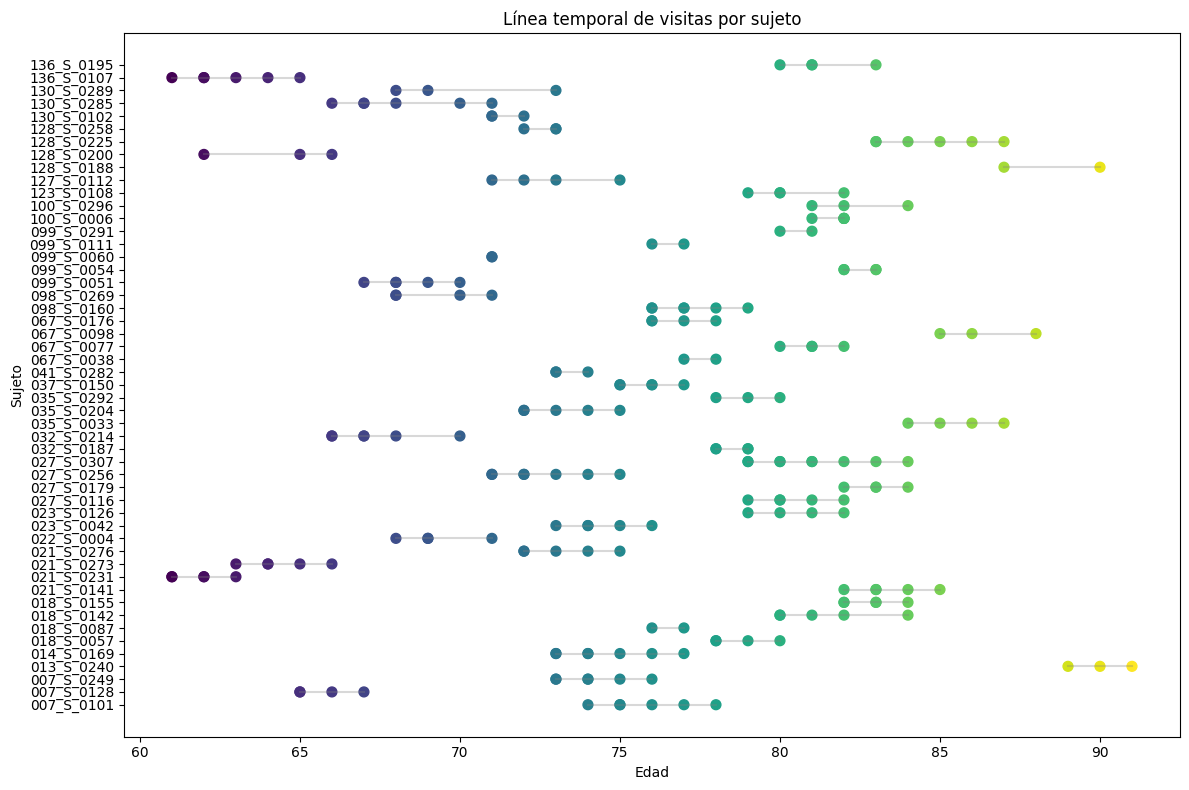

In [41]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(12,8))

# Colormap continuo
colormap = plt.get_cmap("viridis")

# Normalizamos edades entre 0 y 1 para el colormap
ages = df_tab['Age']
norm = plt.Normalize(vmin=ages.min(), vmax=ages.max())

for sid, grupo in df_tab.groupby('sujeto_id'):
    color_values = colormap(norm(grupo['Age']))  # color por edad
    plt.scatter(grupo['Age'], [sid]*len(grupo), c=color_values, s=50)  # puntos
    plt.plot(grupo['Age'], [sid]*len(grupo), color='gray', alpha=0.3)     # línea base

plt.xlabel("Edad")
plt.ylabel("Sujeto")
plt.title("Línea temporal de visitas por sujeto")
plt.tight_layout()
plt.show()


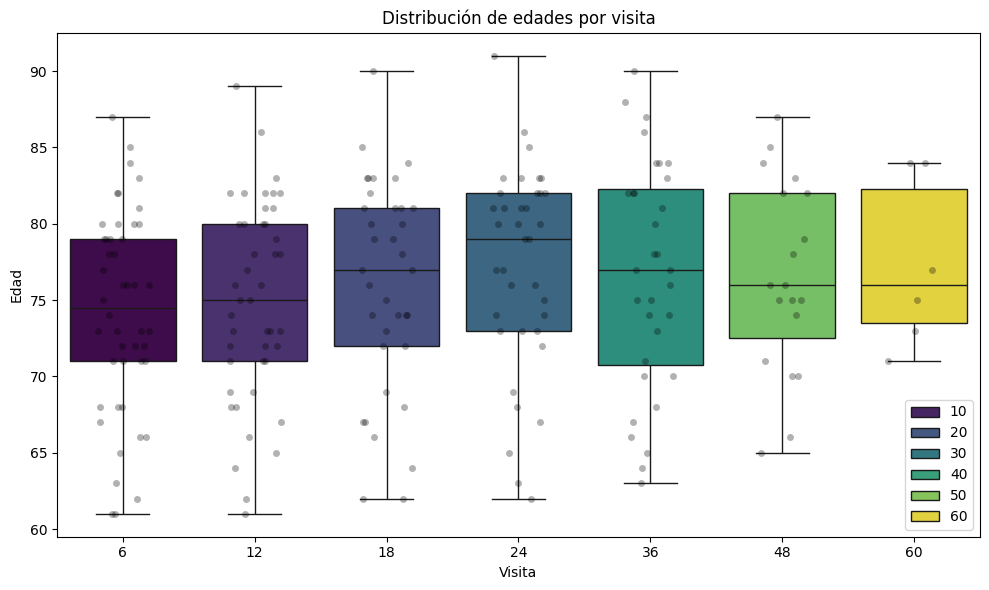

In [43]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_tab, x='Visita', y='Age', palette='viridis', hue='Visita')
sns.stripplot(data=df_tab, x='Visita', y='Age', color='black', alpha=0.3, jitter=0.2)  # opcional: puntos individuales

plt.title("Distribución de edades por visita")
plt.xlabel("Visita")
plt.ylabel("Edad")
plt.tight_layout()
plt.show()


In [70]:
df_tab.columns

Index(['sujeto_id', 'label', 'is_dementia', 'Visita', 'Age', 'Sexo', 'Educat',
       'APOE4_std', 'CDRSB_std', 'MMSE_std', 'ADAS13_std', 'FAQ_std',
       'RAVLT_immediate_std', 'RAVLT_learning_std', 'RAVLT_forgetting_std',
       'DIGITSCOR_std', 'TRABSCOR_std', 'Ventricles_std', 'Hippocampus_std',
       'WholeBrain_std', 'Entorhinal_std', 'Fusiform_std', 'MidTemp_std',
       'ICV_std'],
      dtype='object')

### Biomarcadores

In [53]:
biomarcadores = ['APOE4', 'CDRSB', 'MMSE', 'ADAS13', 'FAQ',
       'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'DIGITSCOR',
       'TRABSCOR']

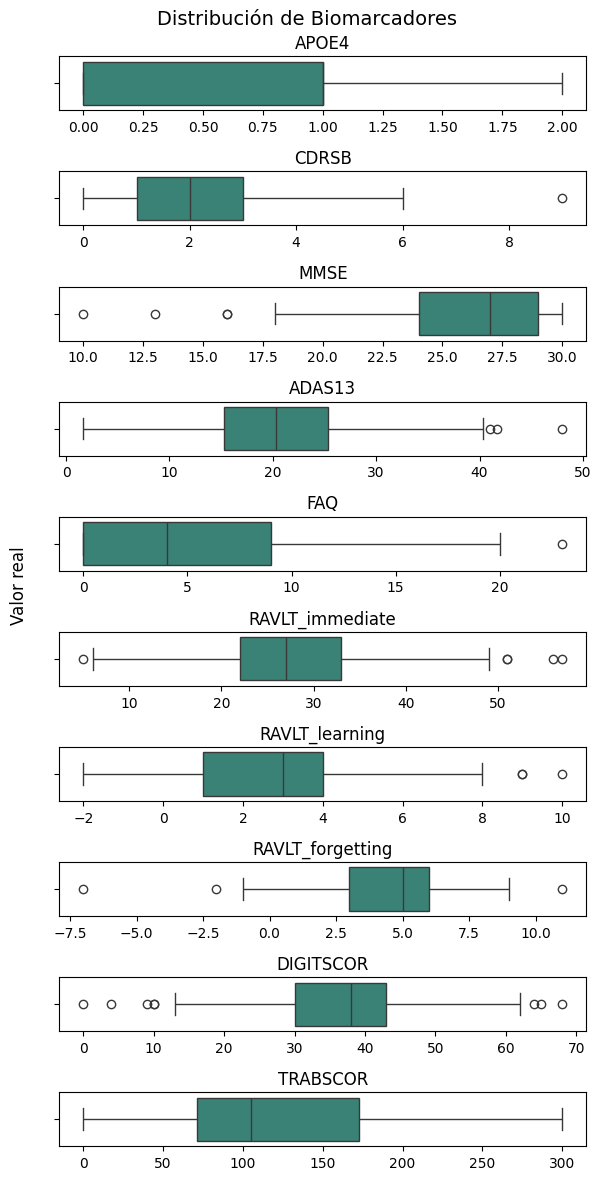

In [66]:
plt.figure(figsize=(6, 12))

for i, biom in enumerate(biomarcadores, 1):
    plt.subplot(len(biomarcadores), 1, i)
    sns.boxplot(x=df_dx[biom], color='#2E8E7E')
    plt.title(biom)
    plt.xlabel("")
plt.suptitle("Distribución de Biomarcadores", fontsize=14)
plt.figtext(0.02, 0.5, "Valor real", ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.05, 0, 1, 1])  # deja espacio para el ylabel global
plt.show()
plt.show()


In [71]:
bio_std = ['APOE4_std', 'CDRSB_std', 'MMSE_std', 'ADAS13_std', 'FAQ_std',
       'RAVLT_immediate_std', 'RAVLT_learning_std', 'RAVLT_forgetting_std',
       'DIGITSCOR_std', 'TRABSCOR_std']


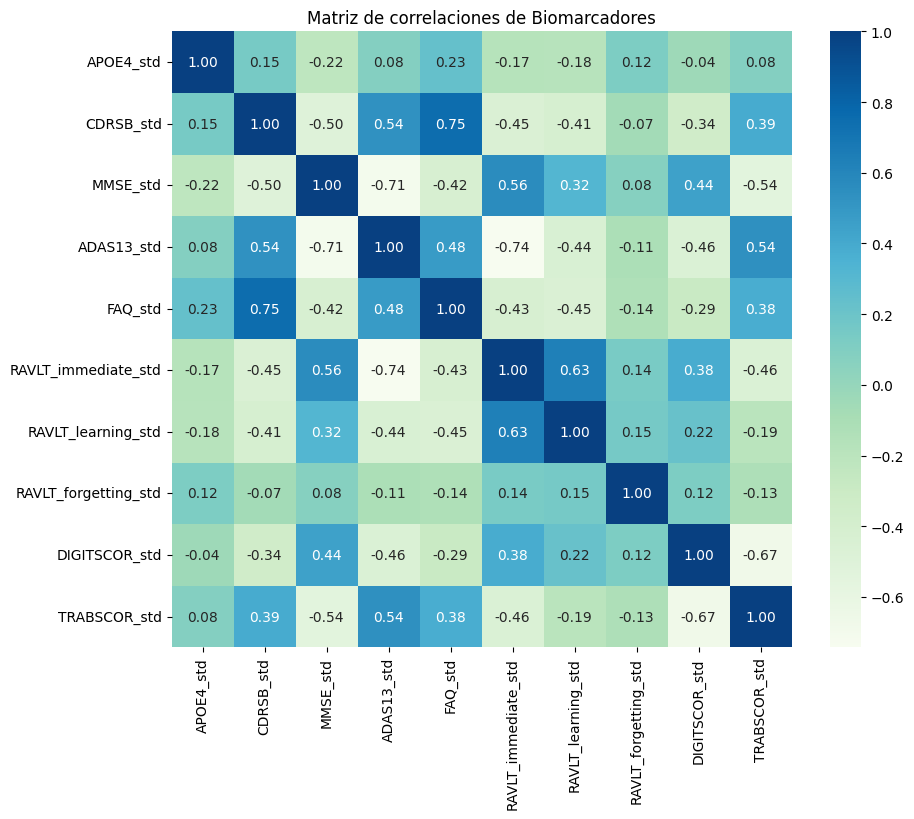

In [77]:
plt.figure(figsize=(10,8))
sns.heatmap(df_tab[bio_std].corr(), annot=True, fmt=".2f", cmap="GnBu")
plt.title("Matriz de correlaciones de Biomarcadores")
plt.show()

### Volúmenes cerbrales

In [67]:
volumen = ['Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal',
       'Fusiform', 'MidTemp', 'ICV']

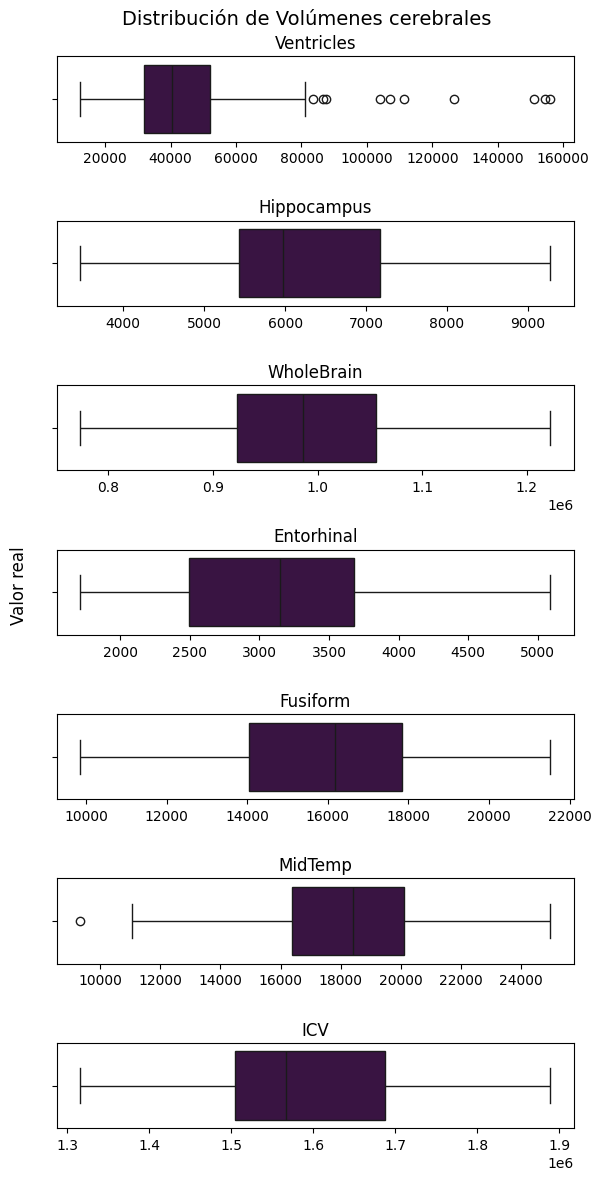

In [69]:
plt.figure(figsize=(6, 12))

for i, biom in enumerate(volumen, 1):
    plt.subplot(len(volumen), 1, i)
    sns.boxplot(x=df_dx[biom], color='#3E0C4A')
    plt.title(biom)
    plt.xlabel("")
plt.suptitle("Distribución de Volúmenes cerebrales", fontsize=14)
plt.figtext(0.02, 0.5, "Valor real", ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.05, 0, 1, 1])  # deja espacio para el ylabel global
plt.show()
plt.show()


In [76]:
volumn_std =[
    'Ventricles_std', 'Hippocampus_std',
       'WholeBrain_std', 'Entorhinal_std', 'Fusiform_std', 'MidTemp_std',
       'ICV_std'
]

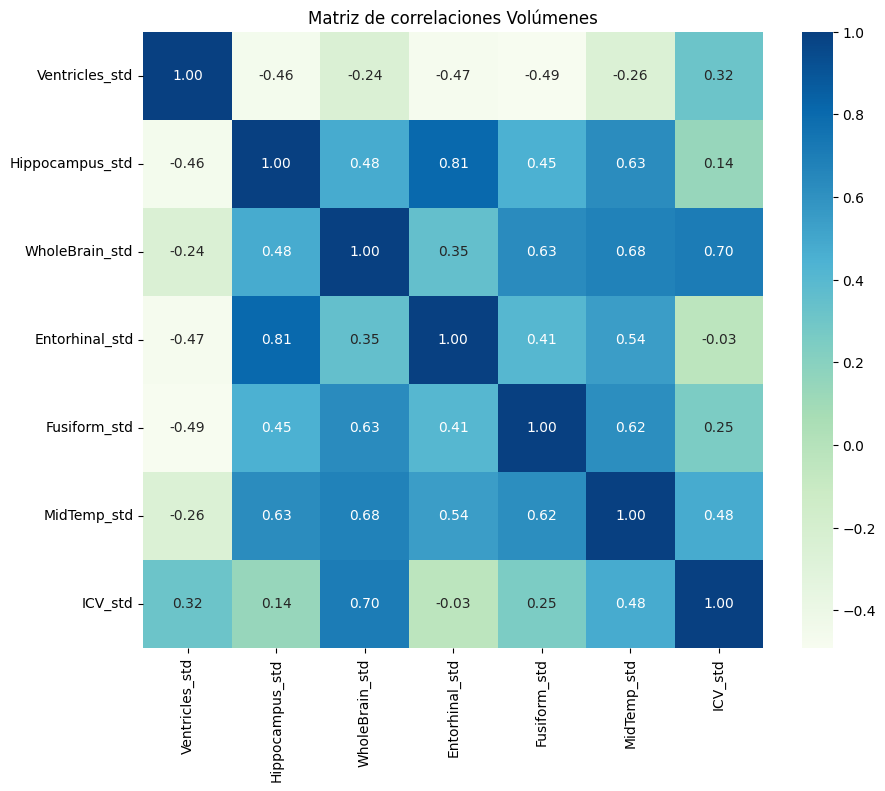

In [79]:
plt.figure(figsize=(10,8))
sns.heatmap(df_tab[volumn_std].corr(), annot=True, fmt=".2f", cmap="GnBu")
plt.title("Matriz de correlaciones Volúmenes")
plt.show()

______________________

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


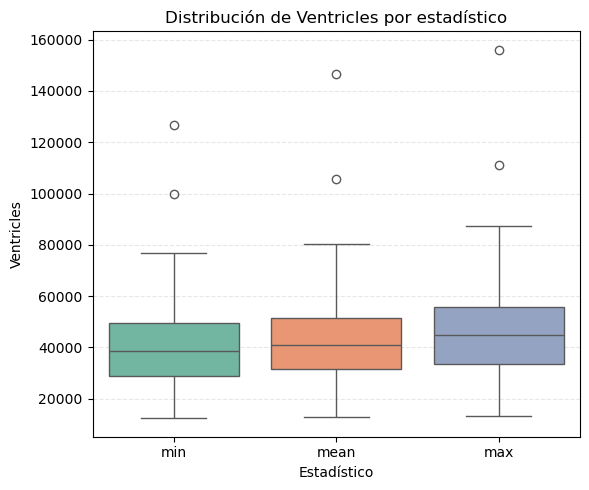

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


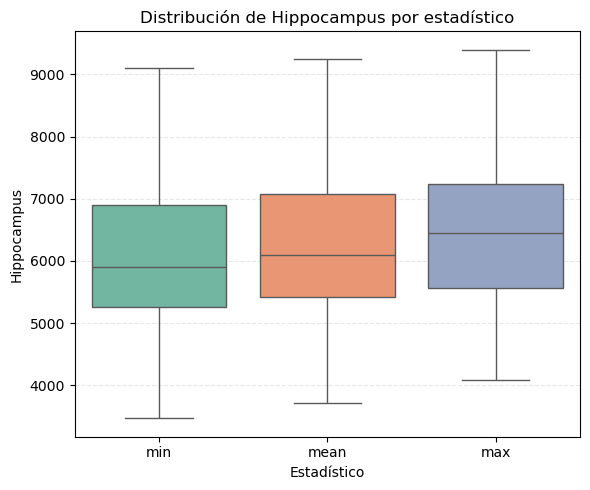

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


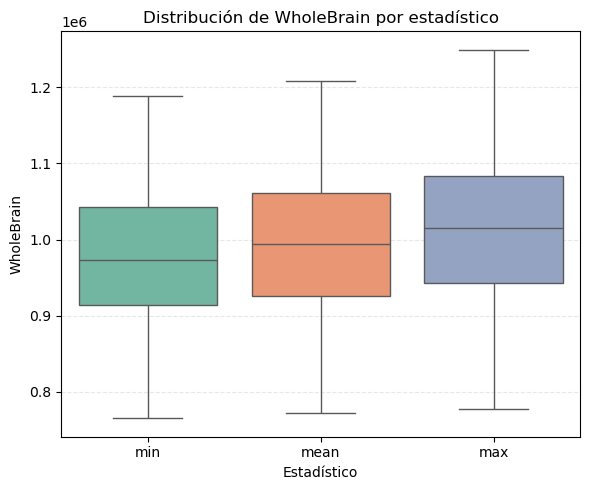

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


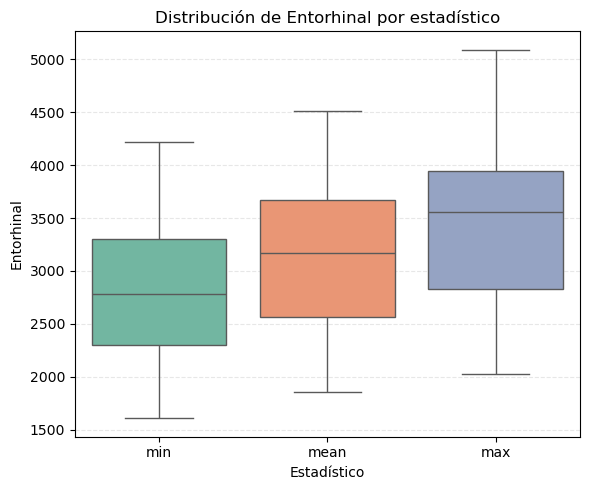

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


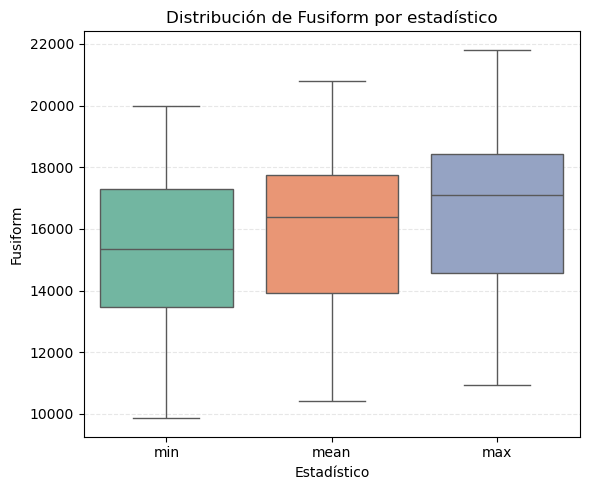

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


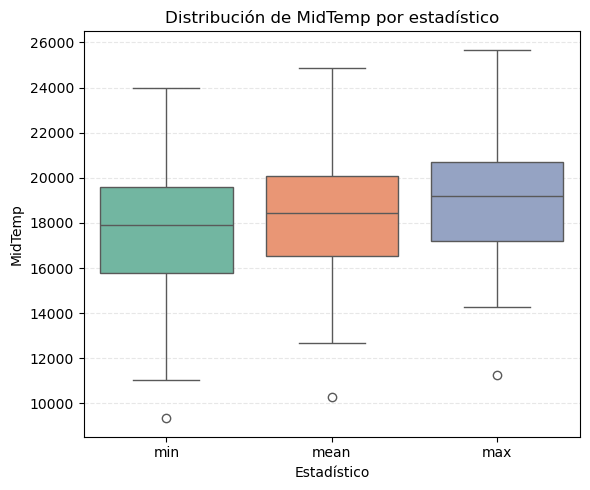

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


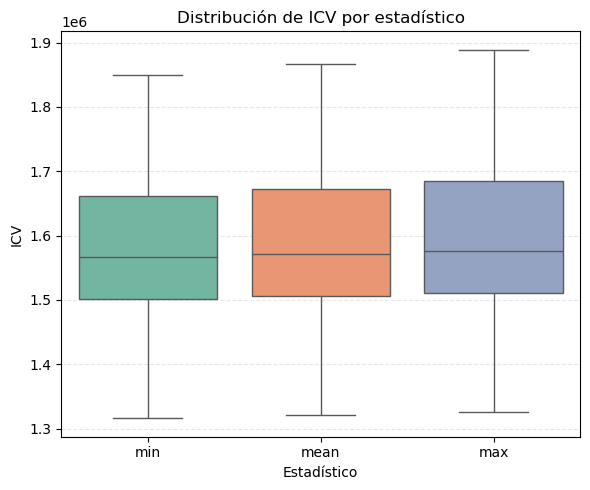

In [ ]:
# Aplanar columnas
info_volumen.columns = ['sujeto_id'] + [f"{var}_{stat}" for var, stat in info_volumen.columns[1:]]

# Convertir a formato largo
info_long = pd.melt(
    info_volumen,
    id_vars="sujeto_id",
    var_name="variable_estadistica",
    value_name="valor"
)

# Separar nombre de variable y tipo de estadístico
info_long[["variable", "estadistica"]] = info_long["variable_estadistica"].str.rsplit("_", n=1, expand=True)


In [64]:
# Agrupar por variable y estadístico
tabla_resumen = info_long.groupby(["variable", "estadistica"])["valor"].agg(["min", "mean", "max"]).round(2).reset_index()
# Ordenar por variable y tipo de estadístico
tabla_resumen = tabla_resumen.sort_values(["variable", "estadistica"])

# Mostrar
tabla_resumen

,variable,estadistica,min,mean,max
0,Entorhinal,max,2023.00,3481.71,5090.0
1,Entorhinal,mean,1853.00,3157.49,4511.2
2,Entorhinal,min,1608.00,2832.86,4215.0
3,Fusiform,max,10946.00,16742.86,21808.0
4,Fusiform,mean,10424.33,16061.54,20798.8
5,Fusiform,min,9860.00,15365.92,19972.0
6,Hippocampus,max,4087.00,6431.73,9396.0
7,Hippocampus,mean,3717.67,6205.67,9251.5
8,Hippocampus,min,3471.00,5997.59,9102.0
9,ICV,max,1325720.00,1595814.31,1888900.0


Las variables de volumen derivadas de imágenes de resonancia magnética permiten cuantificar la estructura anatómica del cerebro y detectar cambios asociados con la atrofia y el deterioro cognitivo.

En general, los **volúmenes medios** observados muestran una distribución coherente con las variaciones esperadas entre sujetos y posibles etapas de deterioro. El **volumen intracraneal total** (**ICV**) presenta valores promedio cercanos a **1.59 millones de mm³**, siendo una medida anatómica estable que se utiliza para normalizar otras variables de volumen.

El **volumen total cerebral** (**WholeBrain**) muestra valores promedio alrededor del **millón de mm³**, mientras que los **ventrículos** (**Ventricles**) presentan una alta variabilidad (media ≈ 47.000 mm³), lo cual es característico de la expansión ventricular asociada a procesos de atrofia cortical.

Regiones críticas vinculadas con la memoria, como el **hipocampo** (**Hippocampus**) y la **corteza entorrinal** (**Entorhinal**), presentan volúmenes medios de aproximadamente **6.200 mm³** y **3.100 mm³**, respectivamente. La reducción en estas áreas se considera uno de los primeros indicadores estructurales del Alzheimer.

Por otro lado, estructuras del lóbulo temporal, como el **giro fusiforme** (**Fusiform**) y el **lóbulo temporal medio** (**MidTemp**), presentan volúmenes intermedios (entre **15.000 y 18.000 mm³**), reflejando su participación en procesos de reconocimiento visual y auditivo.

En conjunto, los resultados muestran una tendencia esperada de atrofia progresiva, principalmente en regiones temporales y de memoria, mientras que **ICV** y **WholeBrain** actúan como referencias anatómicas estables para la comparación entre sujetos y sesiones.

## **6. Evolución del Diagnostico por Visita**

In [89]:
tabla_dx = df_dx.pivot_table(
    index="sujeto_id",
    columns="Visit",
    values="DX",
    aggfunc="first"  # Asume que hay una sola entrada por sujeto-visita
).fillna("-") 
tabla_dx

Visit,m06,m12,m18,m24,m36
sujeto_id,,,,,
007_S_0101,MCI,MCI,MCI,Dementia,Dementia
007_S_0128,MCI,MCI,Dementia,-,-
007_S_0249,MCI,Dementia,Dementia,Dementia,Dementia
013_S_0240,-,MCI,Dementia,-,-
014_S_0169,MCI,MCI,MCI,MCI,MCI
018_S_0057,MCI,MCI,Dementia,Dementia,-
018_S_0087,MCI,-,MCI,-,-
018_S_0142,MCI,MCI,MCI,-,-
018_S_0155,MCI,MCI,MCI,MCI,-


### Diagnostico Inicial vrs Final

In [92]:
df_a = df_dx.sort_values(["sujeto_id", "Visit"]).groupby("sujeto_id").agg(
    dx_inicio=("DX", "first"),
    dx_final=("DX", "last")
).reset_index()
tabla_transicion = df_a.groupby(["dx_inicio", "dx_final"]).size().unstack(fill_value=0)
tabla_transicion

dx_final,Dementia,MCI
dx_inicio,,
Dementia,3,0
MCI,17,30


El diagnóstico inicial muestra que todos los participantes comenzaron el estudio con **deterioro cognitivo leve (MCI)**. Sin embargo, al finalizar el seguimiento, **22 de ellos progresaron a demencia**, mientras que **29 se mantuvieron en la misma condición**. Esto refleja una tendencia esperada en la evolución clínica del MCI, donde una proporción significativa de pacientes presenta un empeoramiento cognitivo a lo largo del tiempo, mientras que otros permanecen estables.


_________________